In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
from ingest.ohlcv import get_connection

We establish a database connection, load price data, select a single ticker, resample to business-day frequency (Mon–Fri), and forward-fill missing values.

In [2]:
with get_connection() as conn:
    df = pd.read_sql("SELECT * FROM ohlcv", conn)

df = df[df["ticker"] == "BBVA.MC"]
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df = df.asfreq("B")
df["close"] = df["close"].ffill()
df.head(1)

,ticker,open,high,low,close,volume
date,,,,,,
2021-01-05,BBVA.MC,4.04,4.093,4.022,4.074,10364379.0


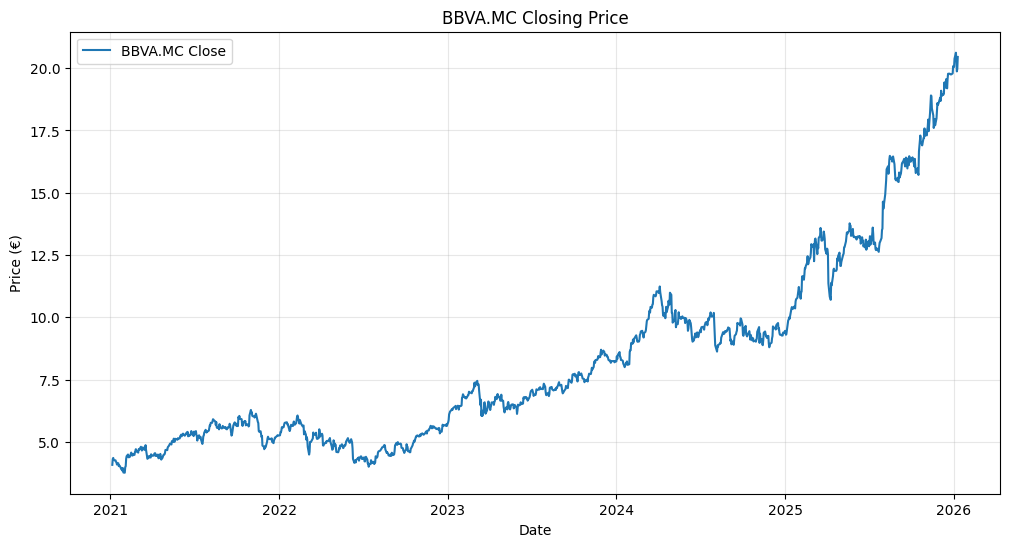

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="BBVA.MC Close", linewidth=1.5)

plt.title("BBVA.MC Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (€)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

We plot the original closing price series and visually observe a clear trend, indicating that the series is non-stationary.

In [4]:
test = adfuller(df["close"])
stationarity_interpretation = (
    "Stationary" if test[1] < 0.05 else "Non-Stationary"
)
print(f"ADF Statistic: {test[0]}")
print(f"p-value: {test[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic: 2.111496645035932
p-value: 0.9988014146577279
Interpretation: The series is Non-Stationary.


We apply the Augmented Dickey–Fuller (ADF) test to formally assess stationarity. This confirms the series is non-stationary.

In [5]:
prices = df["close"]
log_returns = np.log(prices).diff().dropna()
test = adfuller(log_returns)
stationarity_interpretation = (
    "Stationary" if test[1] < 0.05 else "Non-Stationary"
)
print(f"ADF Statistic: {test[0]}")
print(f"p-value: {test[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic: -21.86984925171074
p-value: 0.0
Interpretation: The series is Stationary.


We compute log returns to transform the series into a more symmetric distribution of gains and losses (vs. returns). Log returns are also preferred over prices (scale dependent). Differencing ensures stationarity which is confirmed with the ADF test.

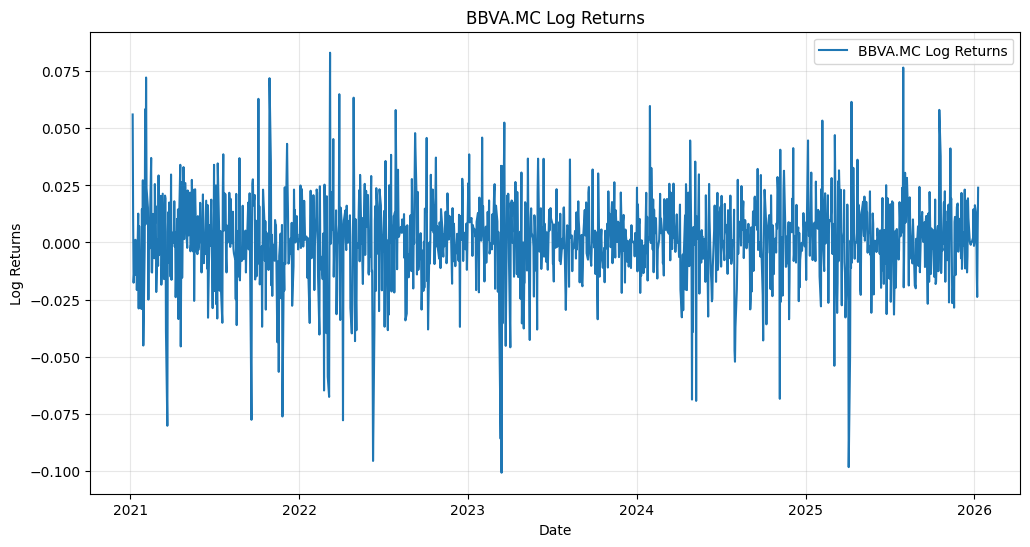

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(log_returns.index, log_returns, label="BBVA.MC Log Returns", linewidth=1.5)

plt.title("BBVA.MC Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

We plot the log returns series to visually inspect stationarity and assess the distribution of gains and losses over time.

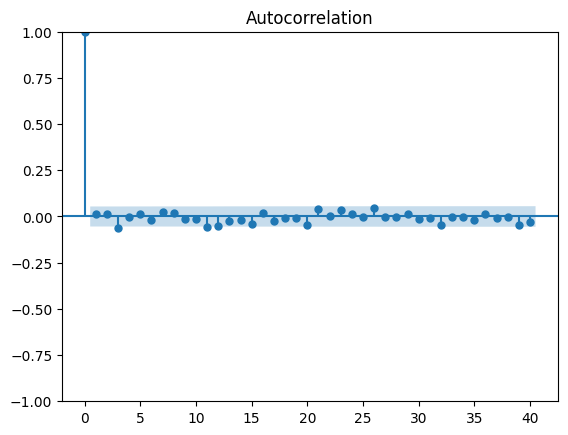

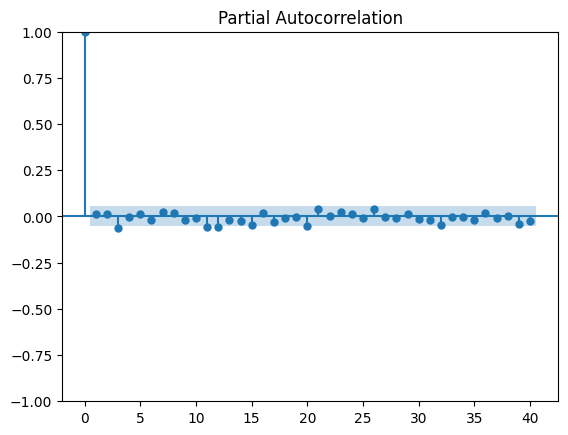

In [7]:
plot_acf(log_returns,lags=40);
plot_pacf(log_returns, lags=40);

We plot the autocorrelation (ACF) and partial autocorrelation (PACF) of the log returns. Only the lag-0 correlation is significant, suggesting no meaningful temporal dependencies. Based on this, we select ARIMA(0,0,0), indicating that log returns behave like white noise.

In [8]:
p,d,q = 0,0,0
model = ARIMA(log_returns, order=(p,d,q))
model_fit = model.fit()
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1308
Model:                          ARIMA   Log Likelihood                3299.294
Date:                Tue, 13 Jan 2026   AIC                          -6594.588
Time:                        18:54:03   BIC                          -6584.235
Sample:                    01-06-2021   HQIC                         -6590.704
                         - 01-09-2026                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      2.226      0.026       0.000       0.002
sigma2         0.0004   9.13e-06     41.337      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               736.73
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

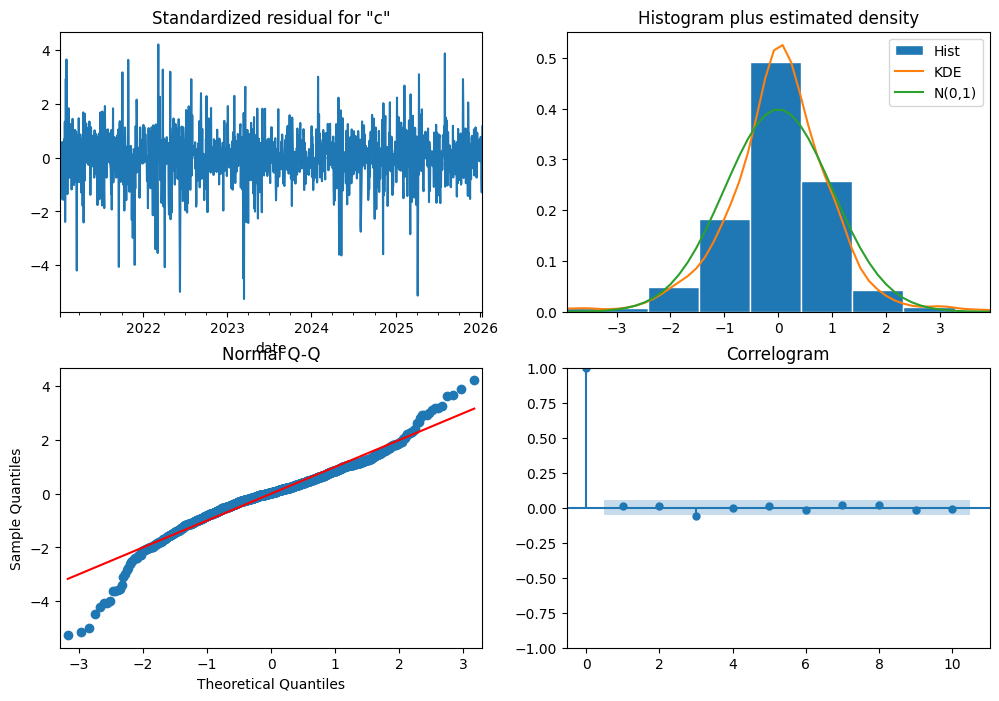

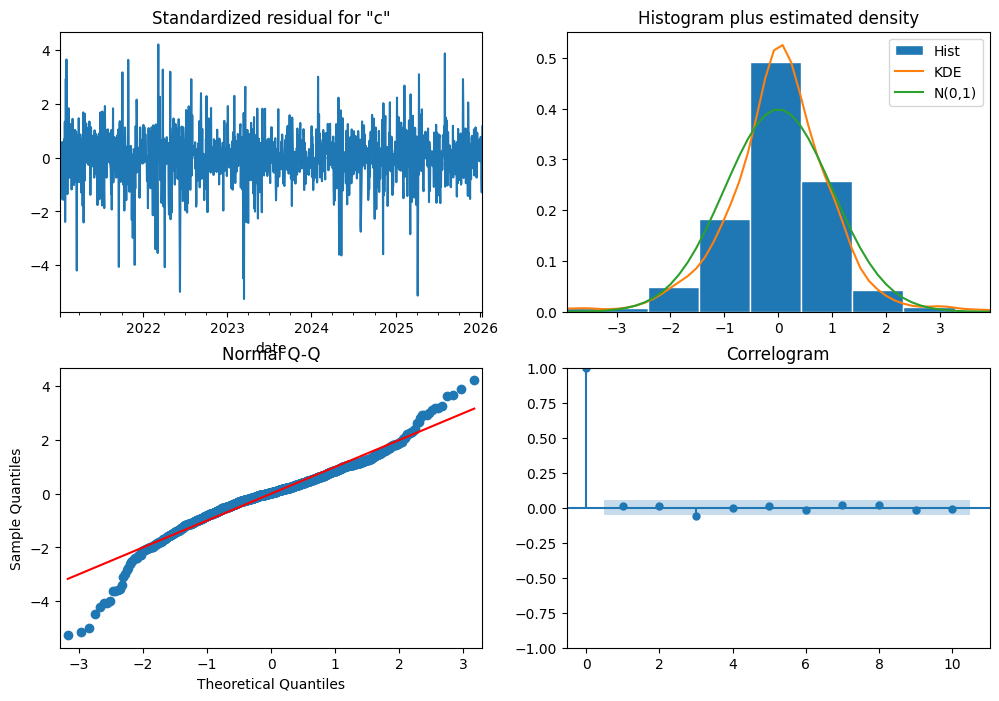

In [9]:
model_fit.plot_diagnostics(figsize=(12,8))

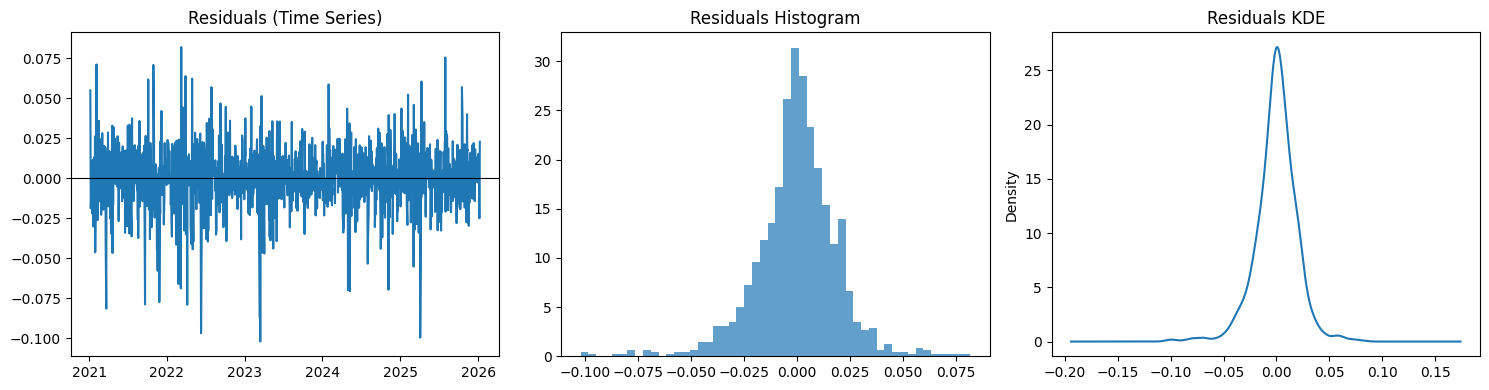

In [10]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(residuals)
axes[0].set_title("Residuals (Time Series)")
axes[0].axhline(0, color="black", linewidth=0.8)

axes[1].hist(residuals, bins=50, density=True, alpha=0.7)
axes[1].set_title("Residuals Histogram")

residuals.plot(kind="kde", ax=axes[2])
axes[2].set_title("Residuals KDE")

plt.tight_layout()
plt.show()


In [11]:
train_size = int(len(log_returns) * 0.8)
train = log_returns.iloc[:train_size]
test = log_returns.iloc[train_size:]

p,d,q = 0,0,0
p_model = ARIMA(train, order=(p,d,q))
p_model_fit = p_model.fit()
forecast = p_model_fit.forecast(steps=len(test))

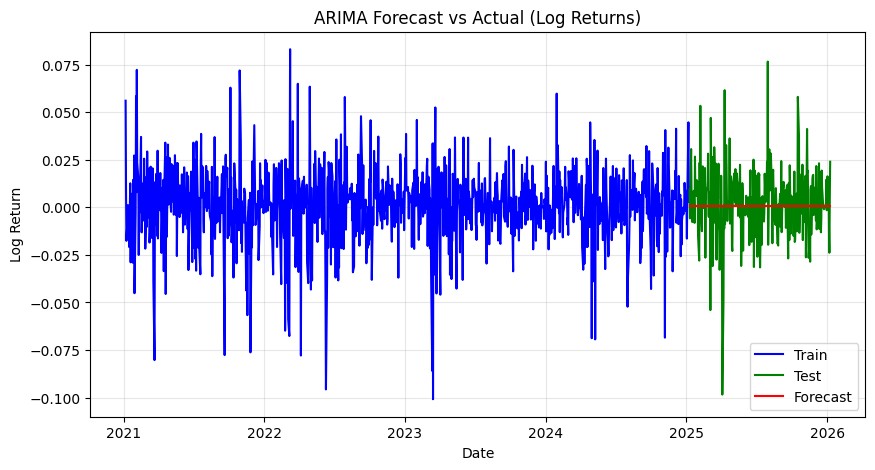

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')

plt.title('ARIMA Forecast vs Actual (Log Returns)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


We plot the ARIMA forecast for log returns. The model predicts the mean return, resulting in a nearly flat line around 0.

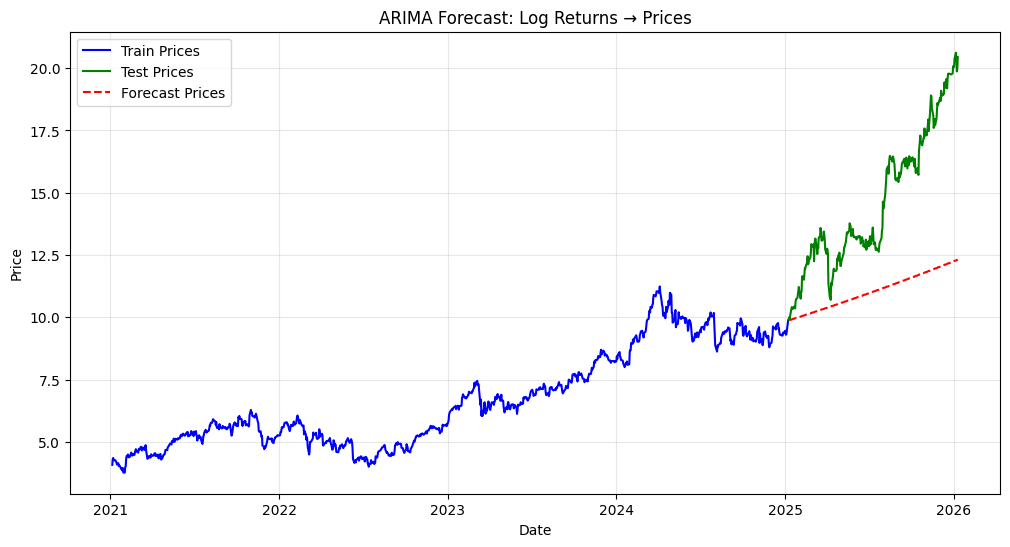

In [13]:
last_train_price = prices.iloc[train_size-1]
price_forecast = last_train_price * np.exp(forecast.cumsum())

test_prices = prices.iloc[train_size:]
train_prices = prices.iloc[:train_size]

price_forecast.index = test_prices.index[1:]

plt.figure(figsize=(12, 6))

plt.plot(train_prices.index, train_prices, label="Train Prices", color="blue")
plt.plot(test_prices.index, test_prices, label="Test Prices", color="green")

plt.plot(price_forecast.index, price_forecast, label="Forecast Prices", color="red", linestyle="--")

plt.title("ARIMA Forecast: Log Returns → Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.legend()
plt.show()



We reconstruct the price forecast from the predicted log returns. We can clearly observe that uncertainty grows with horizon as variance increases with time.

In [14]:
rmse_price = np.sqrt(mean_squared_error(test_prices.iloc[1:], price_forecast))
print(f"RMSE (Price): {rmse_price:.4f} €")

rmse_return = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE (Log Returns): {rmse_return:.6f}")

RMSE (Price): 4.1500 €
RMSE (Log Returns): 0.018507


In [15]:
train_size = int(len(log_returns)-7)
train = log_returns.iloc[:train_size]
test = log_returns.iloc[train_size:]

p,d,q = 0,0,0
op_model = ARIMA(train, order=(p,d,q))
op_model_fit = op_model.fit()
forecast = op_model_fit.forecast(steps=len(test))

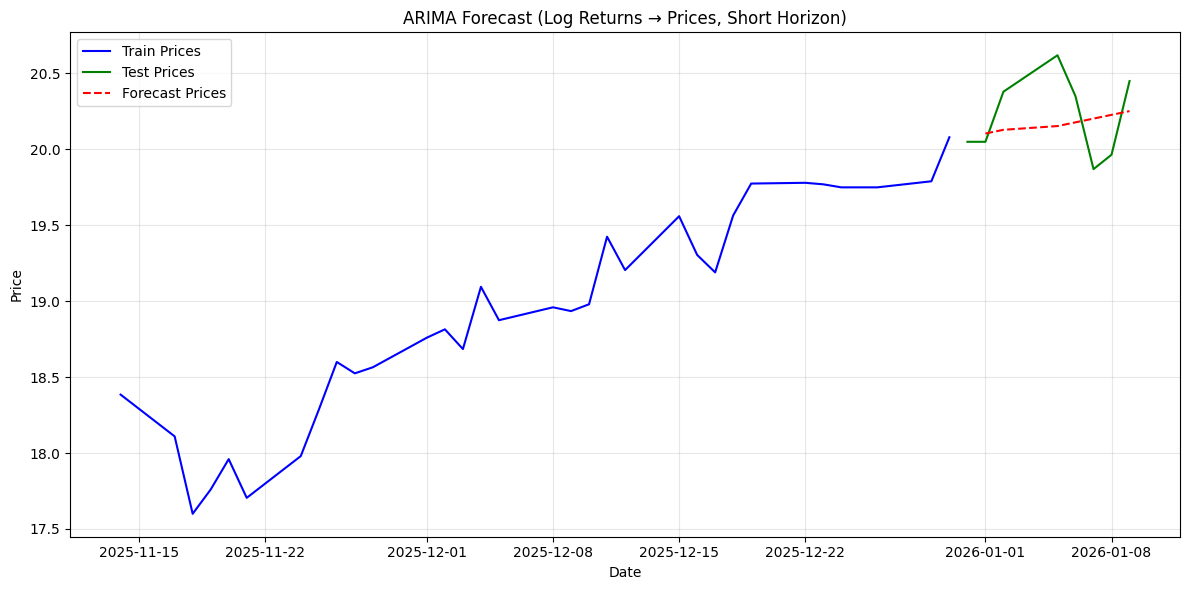

In [16]:
last_train_price = prices.iloc[train_size-1]
price_forecast = last_train_price * np.exp(forecast.cumsum())

test_prices = prices.iloc[train_size:]
train_prices = prices.iloc[:train_size]

zoom_window = 33

plot_start = train_size - zoom_window
zoom_train_prices = prices.iloc[plot_start:train_size]
zoom_test_prices = prices.iloc[train_size:]

plt.figure(figsize=(12, 6))

plt.plot(
    zoom_train_prices.index,
    zoom_train_prices,
    label="Train Prices",
    color="blue"
)

plt.plot(
    zoom_test_prices.index,
    zoom_test_prices,
    label="Test Prices",
    color="green"
)

plt.plot(
    price_forecast.index,
    price_forecast,
    label="Forecast Prices",
    color="red",
    linestyle="--",
)

plt.title("ARIMA Forecast (Log Returns → Prices, Short Horizon)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The model is most effective for short-term forecasts

In [17]:
rmse_price = np.sqrt(mean_squared_error(test_prices.iloc[1:], price_forecast))
print(f"RMSE (Price): {rmse_price:.4f} €")

rmse_return = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE (Log Returns): {rmse_return:.6f}")

RMSE (Price): 0.2756 €
RMSE (Log Returns): 0.015621
